In [2]:
import numpy as np
import pandas as pd
import scipy
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm as norm
import time

## Box-Muller Method for Normal Deviates

The inversion method works well only for the few target distributions with a closed-form ICDF or quantile function, e.g. the exponential distribution. However, RVs from almost all distributions can be obtained transforming two (sometimes three) standard uniform random variables. 

Determinent: -1.29 , RunTime: 0.00181


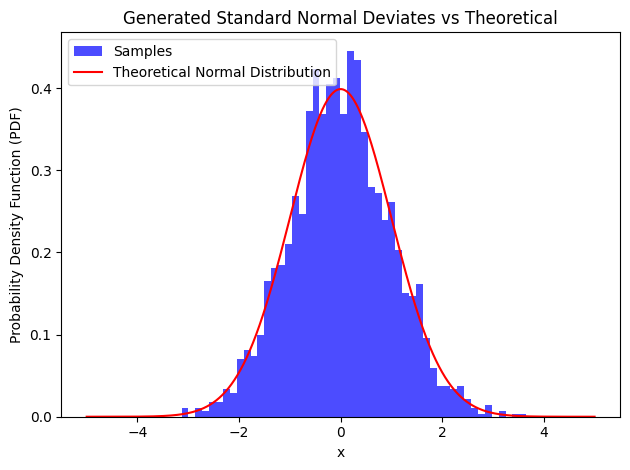

In [23]:
# Parameters
a = -4 # left truncation
b = 4 # right truncation
ngrid = 200 # number of grid steps
nsample = 2000 # number of random samples

# Define the grid using the colon operator
deltax = (b-a)/ngrid # grid step
x = np.linspace(a,b,ngrid) # grid

def box_muller(n, mu, sigma):
    start = time.time()
    u1 = np.random.rand(n//2)
    u2 = np.random.rand(n//2)
    y1 = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
    y2 = np.sqrt(-2 * np.log(u1)) * np.sin(2 * np.pi * u2)

    z1 = np.concatenate([y1, y2])
    z2 = mu + sigma * z1

    det = -1/2*np.pi * np.exp(-0.5*(y1**2+y2**2))

    end = time.time()

    return z1, z2, det, end-start

mu = 0
sigma = 1
z1, z2, det, runtime = box_muller(nsample, mu, sigma)

print('Determinant:',round(det[0],2),', RunTime:',round(runtime,5))
plt.hist(z1, density=True, bins=50, alpha=0.7, color='blue', label='Samples')
x = np.linspace(-5, 5, 1000)
theoretical_normal = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
plt.plot(x, theoretical_normal, 'r', label='Theoretical Normal Distribution')
plt.title('Generated Standard Normal Deviates vs Theoretical')
plt.xlabel('x')
plt.ylabel('Probability Density Function (PDF)')
plt.legend(loc=2)
plt.tight_layout()

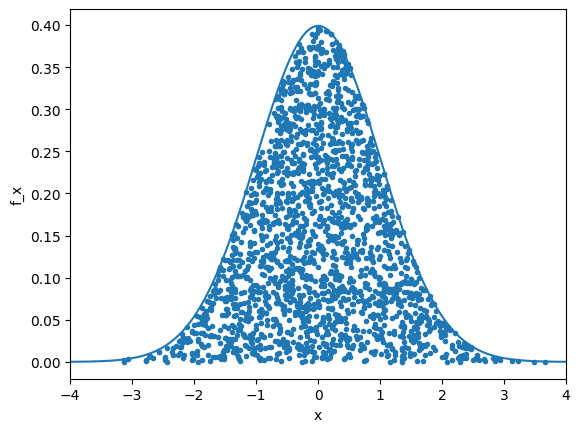

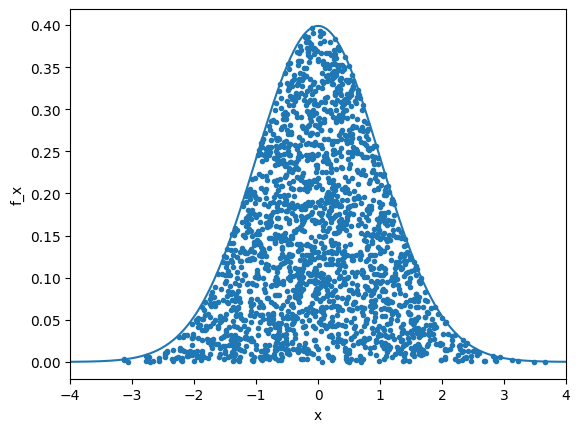

In [24]:
U = np.random.rand(nsample)
plt.scatter(z1, U * norm.pdf(z1, mu, sigma), marker='.')
plt.plot(x, norm.pdf(x, mu, sigma))
plt.xlabel('x')
plt.ylabel('f_x')
plt.xlim([a, b])
plt.show()

# Scatter plot for N2
# Similar scatter plot for N2
U = np.random.rand(nsample)
plt.scatter(z2, U * norm.pdf(z2, mu, sigma), marker='.')
plt.plot(x, norm.pdf(x, mu, sigma))
plt.xlabel('x')
plt.ylabel('f_x')
plt.xlim([a, b])
plt.show()

### Variant of Marsaglia (Polar Method)

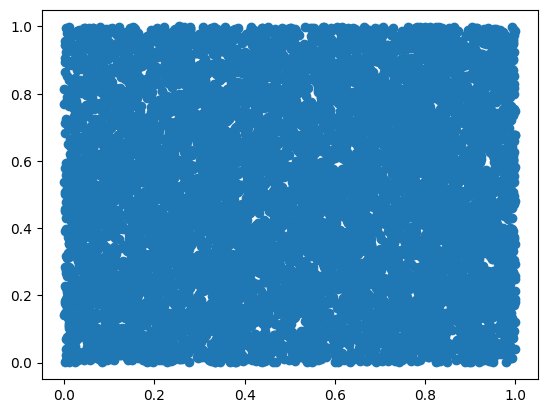

In [ ]:
def arg(x,y):
    angle = np.arctan2(y,x)
    if angle < 0:
        angle+=2*np.pi
    return angle

def polar_method(n):
    while True:
        start = time.time()
        u1 = 2 * np.random.rand(n) - 1
        u2 = 2 * np.random.rand(n) - 1 
        r_squared = u1**2 + u2**2

        mask = (r_squared > 0) & (r_squared <= 1)
        if np.any(mask):
            z1 = u1[mask] * np.sqrt(-2 * np.log(r_squared[mask]) / r_squared[mask])
            z2 = u2[mask] * np.sqrt(-2 * np.log(r_squared[mask]) / r_squared[mask])
            end = time.time()
            return z1, z2, end-start


num_samples = 10000
## Prove they're uniformly distributed
pair = []
pair2 = []
while len(pair)<num_samples:
    u1, u2 = np.random.rand(), np.random.rand()
    v1, v2 = 2*u1-1, 2*u2-1
    w = v1**2 + v2**2

    if w < 1:
        x1 = w
        x2 = arg(v1,v2)/(2*np.pi)
        pair.append(x1)
        pair2.append(x2)
plt.scatter(pair,pair2)

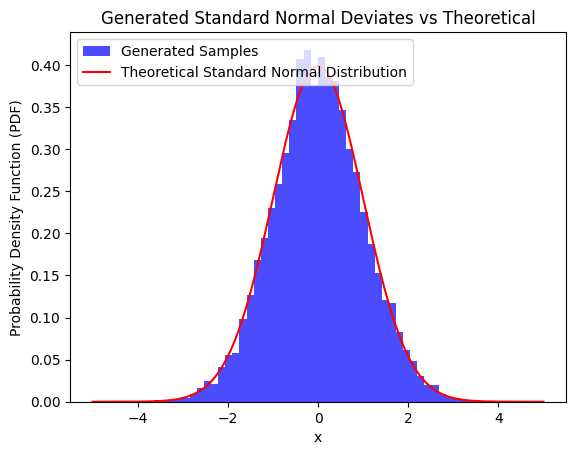

In [ ]:
z1, z2, runtime = polar_method(num_samples)
U = np.random.rand(num_samples)
# plt.scatter(z1,U[:len(z1)]*scipy.stats.norm.pdf(z1,0,1))
plt.hist(z1, bins=50, density=True, alpha=0.7, color='blue', label='Generated Samples')
x = np.linspace(-5, 5, 1000)
theoretical_normal = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
plt.plot(x, theoretical_normal, 'r', label='Theoretical Standard Normal Distribution')
plt.title('Generated Standard Normal Deviates vs Theoretical')
plt.xlabel('x')
plt.ylabel('Probability Density Function (PDF)')
plt.legend(loc=2)

### Ziggurat algorithm 
Issues with simple accept/reject algo:
1. A large proportion of samples will be rejected
2. We must evaluate f(x) for each candidate point, which for many pdfs is computationally expensive.

Ziggurat algorithm addresses these two issues by covering the pdf with a series of horizontal rectangles rather than a single square, and in an arrangement that attempts to cover the pdf as efficiently as possible, i.e with minimum area outside of the pdf curve.

In [ ]:
import time
import ctypes

class Ziggurat(object):
    def __init__(self, mean=0.0, std=1.0, seed=37):
        self.mean = mean
        self.std = std
        self.wn = np.array([0.0 for i in range(128)], dtype=float)
        self.fn = np.array([0.0 for i in range(128)], dtype=float)
        self.kn = np.array([0.0 for i in range(128)], dtype=float)

        self.jsr = 123456789 ^ (seed if seed is not None else int(time.time()))

        m1 = 2147483648.0
        dn = 3.442619855899
        tn = dn
        vn = 9.91256303526217e-3

        q = vn / np.exp(-0.5 * dn * dn)
        self.kn[0] = np.floor((dn / q) * m1)
        self.kn[1] = 0

        self.wn[0] = q / m1
        self.wn[127] = dn / m1

        self.fn[0] = 1.0
        self.fn[127] = np.exp(-0.5 * dn * dn)

        i = 126
        while i >= 1:
            dn = np.sqrt(-2.0 * np.log(vn / dn + np.exp(-0.5 * dn * dn)))
            self.kn[i+1] = np.floor((dn / tn) * m1)
            tn = dn
            self.fn[i] = np.exp(-0.5 * dn * dn)
            self.wn[i] = dn / m1

            i -= 1

    def shr3(self):
        def rshift(val, n):
            if val >= 0:
                return ctypes.c_int(val >> n).value
            else:
                return ctypes.c_int((val+0x100000000) >> n).value

        jz = self.jsr
        jzr = self.jsr
        jzr = ctypes.c_int(jzr ^ (jzr << 13)).value
        jzr = ctypes.c_int(jzr ^ rshift(jzr, 17)).value
        jzr = ctypes.c_int(jzr ^ (jzr << 5)).value
        self.jsr = jzr
        return ctypes.c_int((jz+jzr) | 0).value

    def uni(self):
        return 0.5 * (1.0 + self.shr3() / -np.power(2, 31))

    def uni_safe(self):
        while True:
            u = self.uni()
            if 0 != u:
                return u

    def rnorm(self):
        hz = self.shr3()
        iz = hz & 127
        return self.mean + self.std * (hz * self.wn[iz] if np.abs(hz) < self.kn[iz] else self.nfix(hz, iz))

    def nfix(self, hz, iz):
        r = 3.442619855899
        r1 = 1.0 / r
        x = 0
        y = 0

        while True:
            x = hz * self.wn[iz]
            if iz == 0:
                x = -np.log(self.uni_safe()) * r1
                y = -np.log(self.uni_safe())

                while True:
                    x = -np.log(self.uni_safe()) * r1
                    y = -np.log(self.uni_safe())
                    if y + y >= x * x:
                        break
                return r + x if hz > 0 else -r - x

            if self.fn[iz] + self.uni() * (self.fn[iz-1] - self.fn[iz]) < np.exp(-0.5 * x * x):
                return x

            hz = self.shr3()
            iz = hz & 127

            if np.abs(hz) < self.kn[iz]:
                return hz * self.wn[iz]

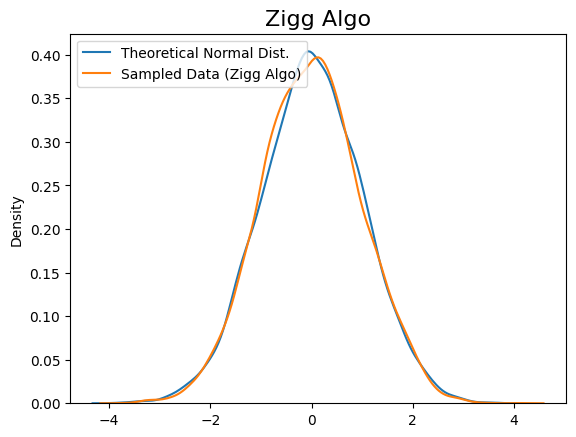

In [ ]:
num_samples = 10000

mean = 0
std = 1
zigg = Ziggurat(mean=mean, std=std)

# x = np.linspace(-5, 5, nsamples)
# theoretical_normal = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
np_samples = np.random.normal(mean, std, num_samples)
zi_samples = np.array([zigg.rnorm() for _ in range(num_samples)])

plt.title('Zigg Algo', size=16)
sns.kdeplot(np_samples, label = 'Theoretical Normal Dist.')
sns.kdeplot(zi_samples, label = 'Sampled Data (Zigg Algo)')
plt.legend(loc=2)